In [1]:
!subst N: E:\Network_Data_Sync
!subst S: E:\Network_Data_Sync
!subst O: "E:\OneDrive - Washington University in St. Louis"

In [141]:
%load_ext autoreload
%autoreload 2

In [204]:
# load corr feat tsr
import numpy as np
from scipy.io import loadmat
from os.path import join
from sklearn.decomposition import NMF
import matplotlib.pylab as plt
from numpy.linalg import norm as npnorm
mat_path = r"E:\OneDrive - Washington University in St. Louis\Mat_Statistics"
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
Animal = "Beto"
Expi = 11
corrDict = np.load(join("S:\corrFeatTsr","%s_Exp%d_Evol_corrTsr.npz"%(Animal,Expi)), allow_pickle=True) # **featFetcher.make_savedict()
cctsr_dict = corrDict.get("cctsr").item()
Ttsr_dict = corrDict.get("Ttsr").item()

In [203]:
ReprStats = loadmat(join(mat_path, Animal + "_ImageRepr.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['ReprStats']

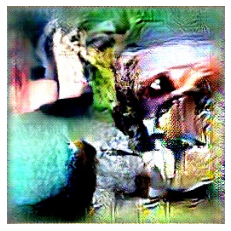

In [212]:
show_img(ReprStats[Expi].Manif.BestImg)

In [119]:
def rectify_tsr(Ttsr, mode="abs", thr=(-5, 5)):
    if mode is "pos_rect":
        Ttsr_pp = np.clip(Ttsr, 0, None)
    elif mode is "abs":
        Ttsr_pp = np.abs(Ttsr)
    elif mode is "thresh":
        Ttsr_pp = Ttsr.copy()
        Ttsr_pp[(Ttsr<thr[1])*(Ttsr>thr[0])] = 0
        Ttsr_pp = np.abs(Ttsr_pp)
    else:
        raise ValueError
    return Ttsr_pp

NMF explained variance 0.394


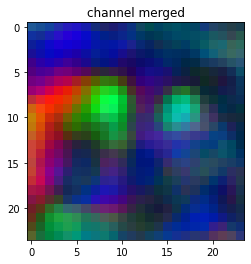

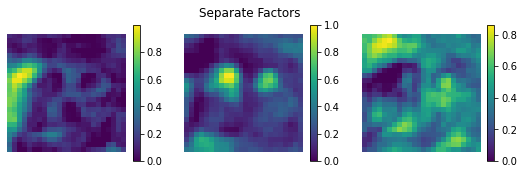

In [190]:
mode = "abs"#"thresh"#pos_rect
thr = (-4,4)
layer = "conv4_3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, mode="thresh")
C, H, W = Ttsr_pp.shape
if bdr == 0:
    Tmat = Ttsr_pp.reshape(C, H*W)
    ccmat = cctsr.reshape(C, H*W)
else:
    Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
#%
nmfsolver = NMF(n_components=3, init="nndsvda", solver="cd")#mu
Hmat = nmfsolver.fit_transform(Tmat.T)
Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, 3])
exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
print("NMF explained variance %.3f"%exp_var)
plt.imshow(Hmaps / Hmaps.max())
plt.title("channel merged")
plt.show()
[figh, axs] = plt.subplots(1,3,figsize=[9, 2.5])
for ci in range(Hmaps.shape[2]):
    plt.sca(axs[ci])
    plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
    plt.axis("off")
    plt.colorbar()
plt.suptitle("Separate Factors")
plt.show()

array([[ 9.233795 ,  9.718565 ,  7.9461827, ..., 10.994765 , 10.000463 ,
         9.229468 ],
       [ 8.552366 ,  8.686569 ,  7.245175 , ..., 10.030194 ,  9.284431 ,
         8.728769 ],
       [ 8.084076 ,  7.845777 ,  6.5208244, ...,  9.131856 ,  9.128148 ,
         8.665923 ],
       ...,
       [ 7.1597385, 12.680461 ,  5.826672 , ...,  9.084945 , 11.098207 ,
         6.541621 ],
       [ 7.5513954, 11.712881 ,  6.2439976, ...,  9.392826 , 10.641441 ,
         7.1079817],
       [ 7.1202674,  8.523932 ,  5.6944556, ...,  8.268019 ,  8.99465  ,
         7.3807116]], dtype=float32)

In [191]:
featvecs = nmfsolver.components_
fact_norms = []
for i in range(Hmaps.shape[2]):
    rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
    matnorm = npnorm(rank1_mat, ord="fro")
    fact_norms.append(matnorm)
    print("Factor%d norm %.2f"%(i, matnorm))

Factor0 norm 1331.94
Factor1 norm 2132.58
Factor2 norm 1866.22


In [198]:
ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
# ccfactor = (ccmat @ Hmat )
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

0.538764328784472

Now let's load up the network and Generator, visualize the contents for this neuron group / feature vector

In [195]:
from CorrFeatTsr_visualize import CorrFeatScore, corr_GAN_visualize, preprocess

In [ ]:
from GAN_utils import upconvGAN
import torch
from torchvision import models
VGG = models.vgg16(pretrained=True)
VGG.requires_grad_(False)
VGG.features.cuda()
G = upconvGAN("fc6").cuda()
G.requires_grad_(False)

Visualize the feature vector without spatial structure, (full feature map)

E:\Github_Projects\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
step 89, score 35.07 36.33 43.18 37.30: 100%|██████████| 90/90 [00:08<00:00, 10.89it/s]


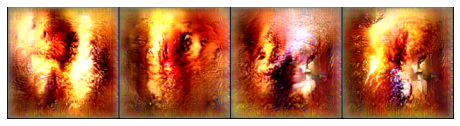

Feature Correlator Destructed, Hooks deleted.
Feature Correlator Destructed, Hooks deleted.
Feature Correlator Destructed, Hooks deleted.


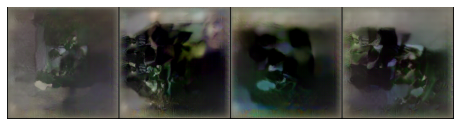

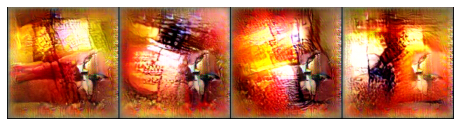

In [199]:
for ci in [0, 1, 2]:
    fact_W = torch.from_numpy(ccfactor[:, ci]).reshape([-1,1,1])
    scorer = CorrFeatScore()
    scorer.register_weights({layer: fact_W})
    scorer.register_hooks(VGG, layer, netname="vgg16")
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.025, MAXSTEP=90, imshow=True, verbose=False)
    scorer.clear_hook()

Visualize the feature vector times the spatial mask from regressing the correlation tensor, (structured feature map)

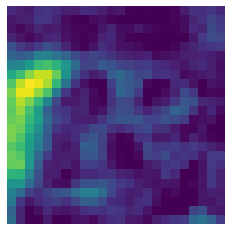

E:\Github_Projects\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
step 99, score 0.06 0.07 0.06 0.07: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


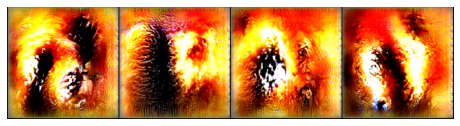

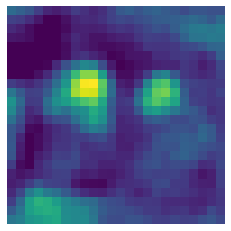

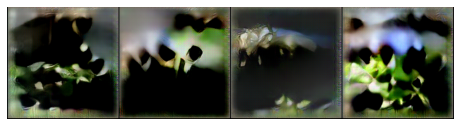

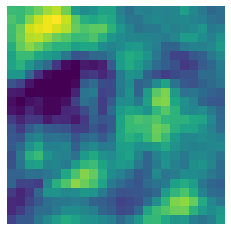

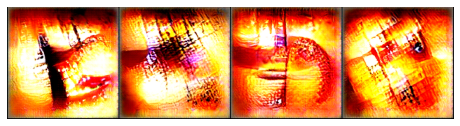

In [213]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    padded_mask = np.pad(Hmaps[:,:,ci:ci+1], ((bdr,bdr),(bdr,bdr),(0,0)))
    fact_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], padded_mask))
    show_img(Hmaps[:,:,ci:ci+1])
    scorer.register_weights({layer: fact_Wtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.1, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

Visualize the feature vector at the center of the feature map, (structured feature map)

E:\Github_Projects\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
step 99, score 0.33 0.37 0.45 0.55: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


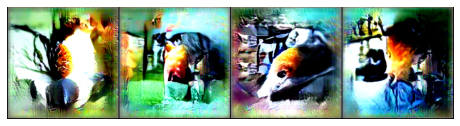

Feature Correlator Destructed, Hooks deleted.
Feature Correlator Destructed, Hooks deleted.


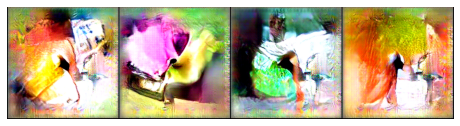

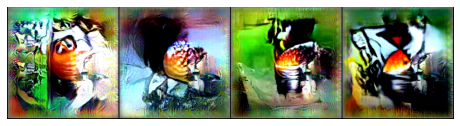

In [200]:
scorer = CorrFeatScore()
scorer.register_hooks(VGG, layer, netname="vgg16")
for ci in [0, 1, 2]:
    H,W,_ = Hmaps.shape
    sp_mask = np.pad(np.ones([2,2,1]), ((H//2-1+bdr,H-H//2-1+bdr),(W//2-1+bdr, W-W//2-1+bdr),(0,0)))
    fact_Chtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], sp_mask))
    scorer.register_weights({layer: fact_Chtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, VGG.features, preprocess, layername=layer, lr=0.10, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

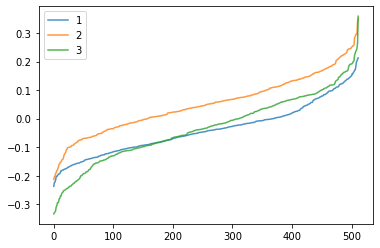

In [111]:
plt.plot(np.sort(ccfactor,axis=0), alpha=0.8)
plt.legend([1,2,3])
plt.show()

In [105]:
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

0.7044371898945597

In [54]:
npnorm(featvecs, axis=1)
npnorm(Hmat, axis=0)

array([113.21262 , 124.157684, 111.78014 ], dtype=float32)

In [ ]:
# reshape to channel by space

# NMF factorize

# Reshape spatial factors

# Normalize spatial factors

# visualize plot 3 channel plot